**Predictive Analytics (Churn Prediction)**

Este es un ejemplo de aplicación de algunos modelos predictivos para identificar a los usuarios que abandonan (churn) los servicios ofrecidos por una organización de la cadena de suministro de telecomunicaciones.

## **1. Pre-procesamiento**
En esta primera sección nos encargaremos de desarrollar un pre-procesamiento de Datos a fin de identificar variables y características clave. Luego, analizar su comportamiento en el contexto de la Cadena de Suministro de las Telecomunicaciones.

**Qué buscamos en esta sección?**
Lo que deseamos lograr mediante este procesamiento preliminar es ajustar las variables y dar formato adecuado a los datos a trabajar en una etapa posterior de EDA.

Empecemos con la importación de aquellas librerías de Python que usaremos para el EDA y la visualización

In [21]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import  Image

import itertools
import warnings
warnings.filterwarnings("ignore")

import io
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'colab'
from plotly.subplots import make_subplots

pd.set_option('display.max_columns', 100)

Ahora, procedamos a cargar el dataset y veamos de qué variables se compone. Luego podemos ver qué dimensiones tiene este conjunto de datos.

In [22]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [23]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [24]:
df.shape

(7043, 21)

Ahora, saquemos un resumen de las variables y verifiquemos si hay columnas con información incompleta.

In [25]:
summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
summary['Missing'] = df.isnull().sum().values
summary['Uniques'] = df.nunique().values
summary

,dtypes,Missing,Uniques
customerID,object,0,7043
gender,object,0,2
SeniorCitizen,int64,0,2
Partner,object,0,2
Dependents,object,0,2
tenure,int64,0,73
PhoneService,object,0,2
MultipleLines,object,0,3
InternetService,object,0,3
OnlineSecurity,object,0,3


En el reporte anterior, podemos identificar que no tenemos valores faltantes (missing) en ninguna variable. Del mismo modo, de manera particular podemos reconocer que el dataset tiene múltiples variables categóricas.

-------------------------------------
Sabiendo lo anterior, podemos calcular algunas métricas descriptivas para aquellas variables numéricas:

In [26]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Ahora desarrollaremos un análisis más profundo sobre las variables.

Por ejemplo, podemos pensar que aunque no se han reportado datos faltantes en las columnas, pueden existir espacios en blanco que pueden ser interpretados como datos faltantes. Asi, veamos si hay columnas que tienen doble espacio:

In [27]:
for column in df.columns:
    if '' in df[column].values or ' ' in df[column].values:
        print(column)

TotalCharges


Dado que si encontramos variables con doble espacio en sus registros, vamos a proceder a reemplazarlos por un unico espacio.

In [28]:
import numpy as np

# Reemplazar dobles espacios en TODAS las columnas de texto
df = df.apply(lambda col: col.str.replace('  ', ' ', regex=False) if col.dtype == 'object' else col)

# Opcional: reemplazar celdas vacías por NaN
df.replace('', np.nan, inplace=True)

Ahora vamos a identificar qué tantos casos hay de valores nulos (null) en la columna 'TotalCharges'. Lo calculamos a partir de la relación existente entre el número total de registros y el número de regístrios nulos.

In [29]:
df.columns = df.columns.str.strip().str.replace(' ', '_')

Ahora identificamos que solo un 0.16% aproximadamente de la totalidad de los registros, son del tipo (null). Es una proporción pequeña y si prescindimos de esos registros, no se alterará significativamente el dataset. Hagámoslo:

In [30]:
df.dropna(axis=0, inplace = True)

Previamente, cuando hicimos un resumen de las variables, logramos identificar que la variable 'TotalCharges' es del tipo 'object'. Esto significa que se reconoce como una variable categórica. Ahora, podemos cambiar el tipo de dato a 'float' para asegurar que sean tratados como valores numéricos continuos.

In [32]:
# Revisar valores nulos
total_instances = df.shape[0]
total_null = df['TotalCharges'].isnull().sum()
print(round((total_null / total_instances) * 100, 2), '%')

# Convertir a float (si es necesario)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

0.0 %


Cambiando de variable, ahora analicemos la columna 'SeniorCitizen'. Se puede identificar que los valores de la columna son ceros y unos. Es un valor numérico binario. Vamos a cambiar esa configuración numérica a una del tipo 'True' y 'False', a fin de favorecer la implementación de algunos modelos predictivos que usan variables categóricas.

In [33]:
df['TotalCharges'] = df['TotalCharges'].astype('float')

Ahora, vamos a revisar qué categorias o posibles valores toman las diferentes variables del dataset *(definamos un límite de cinco elemementos por variable a fin de evitar generar listas muy extensas de posibles datos)*

In [34]:
for column in df.columns:
    print(column +':','\n',np.unique(df[column])[:5],'\n')

customerID: 
 ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' '0011-IGKFF' '0013-EXCHZ'] 

gender: 
 ['Female' 'Male'] 

SeniorCitizen: 
 [0 1] 

Partner: 
 ['No' 'Yes'] 

Dependents: 
 ['No' 'Yes'] 

tenure: 
 [0 1 2 3 4] 

PhoneService: 
 ['No' 'Yes'] 

MultipleLines: 
 ['No' 'No phone service' 'Yes'] 

InternetService: 
 ['DSL' 'Fiber optic' 'No'] 

OnlineSecurity: 
 ['No' 'No internet service' 'Yes'] 

OnlineBackup: 
 ['No' 'No internet service' 'Yes'] 

DeviceProtection: 
 ['No' 'No internet service' 'Yes'] 

TechSupport: 
 ['No' 'No internet service' 'Yes'] 

StreamingTV: 
 ['No' 'No internet service' 'Yes'] 

StreamingMovies: 
 ['No' 'No internet service' 'Yes'] 

Contract: 
 ['Month-to-month' 'One year' 'Two year'] 

PaperlessBilling: 
 ['No' 'Yes'] 

PaymentMethod: 
 ['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check'] 

MonthlyCharges: 
 [18.25 18.4  18.55 18.7  18.75] 

TotalCharges: 
 [18.8  18.85 18.9  19.   19.05] 

Churn: 
 ['No' 'Yes'] 



Podemos identificar en las listas generadas en el paso anterior que hay varias columnas que contienen la categoría 'No Internet service'. Vamos a cambiar esas categorías por un 'No'. Esto con el fin de agrupar, reducir y estandarizar las alternativas de respuesta.

In [35]:
nointernet = []
for column in df.columns:
    if "No internet service" in df[column].unique():
        nointernet.append(column)

for col in nointernet :
    df[col]  = df[col].replace('No internet service', 'No')



```
# Tiene formato de código
```

## **2. Exploratory Data Analysis (EDA)**

En esta sección tomamos como input los datos procesados y ajustados en formato. Posteriormente, realizamos un Análisis Exploratorio de Datos (EDA) a las variables que esten asociadas al abandono de usuarios. Esto permitirá seleccionar un conjunto de modelos predictivos para implementar y proyectar los abandonos de clientes.

Para iniciar, veamos la variable clave denomindada 'Churn'. Identifiquemos mediante una gráfica cómo se distribuyen los datos:

In [36]:
label = list(df['Churn'].unique())
value = df['Churn'].value_counts()
value_percent = list(round(value/df.shape[0],2))

In [37]:
t1 = go.Bar(
    x=label,
    y=value_percent,
    width = [0.5, 0.5],
    marker=dict(
        color=['green', 'blue'])
    )


layout = go.Layout(dict(
    title='Overall Customer Churn Rate',
    plot_bgcolor  = "rgb(243,243,243)",
    paper_bgcolor = "rgb(243,243,243)",
    xaxis = dict(
        gridcolor = 'rgb(255, 255, 255)',
        title = "Churn",
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2
        ),
    yaxis = dict(
        gridcolor = 'rgb(255, 255, 255)',
        title = "Percent",
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2
        ),
    )
)

fig = go.Figure(data=t1, layout=layout)
fig.update_layout(title_x=0.5)
py.iplot(fig)

***Tasa de abandono de usuarios asociada a variables categóricas***

En el análisis de entrada de las variables, hemos identificado que tenemos un gran número de variables categóricas. Incluso, convertimos la variable 'TotalCharges' de numérica a categórica. Tomando ventaja de esta naturaleza de las variables, podemos preparar algunas funciones para graficar en bloque el comportamiento del 'Churn' frente a cada una de las variables categoricas.

_______________
Para empezar configuraremos aquellos casos positivos de abandono ('Churn' -> 'Yes') como simplemente **'churn'**. En simultáneo, dejaremos los casos de ('Churn' -> 'No') como  **'retention'**:

In [38]:
churn = df[df['Churn'] == True]
retention = df[df['Churn'] == False]

Para configurar adecuadamente los datos vamos a crear una función para redondear a dos ubicaciones decimales algunas variables.

In [39]:
import math

def round_decimals_up(og_list, decimals:int=2):
    """
    Returns rounded up list to a specific number of decimal places.
    """

    rounded_list = []
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals

    for number in og_list:

        rounded_list.append((math.ceil(number * factor) / factor))

    return rounded_list

Ahora, programamos una función que sirva como plantilla para generar los diagramas de barra para cada una de las variables categoricas que deseemos.

In [40]:
def barplot_rounded(col):

    rounded_churn = round_decimals_up((churn[col].value_counts()/churn.shape[0]),3)
    rounded_retention = round_decimals_up((retention[col].value_counts()/retention.shape[0]),3)

    t1 = go.Bar(
        x = list(churn[col].value_counts().keys()),
        y = rounded_churn,
        name = 'Churn',
        marker_color = 'rgb(55, 83, 109)'
    )

    t2 = go.Bar(
        x = list(retention[col].value_counts().keys()),
        y = rounded_retention,
        name = 'Retention',
        marker_color = 'rgb(26, 118, 255)'
    )

    data = [t1,t2]

    layout = go.Layout(dict(
        title = "Churn Rate by " + col,
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor = "rgb(243,243,243)",
        xaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = col,
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        yaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = "Percent",
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        )
    )

    fig  = go.Figure(data=data,layout=layout)
    fig.update_layout(title_x=0.5)
    py.iplot(fig)

En este punto esta lista la función 'barplot_rounded' la cual recibirá la variable categorica en la que evaluaremos la cantidad de 'churn' y de 'retention'. Esto nos dará una idea clara de la relación entre dichas variables. No obstantes, antes de esto, vamos a verificar en este punto cuáles variables tienen al menos cuatro categorías. (P.ejemplo, la variable 'gender' tiene 2 en este dataset).

In [41]:
df.nunique()[df.nunique() <= 4]

,0
gender,2
SeniorCitizen,2
Partner,2
Dependents,2
PhoneService,2
MultipleLines,3
InternetService,3
OnlineSecurity,2
OnlineBackup,2
DeviceProtection,2


Ahora, saquemos un listado de las variables categoricas que cumplen la condición anterior y despleguemos el proceso de generación de gráficas en bloque.

In [42]:
categorical = df.nunique()[df.nunique() <= 4].index[:-1]

In [46]:
categorical

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [45]:
for col in categorical:
    barplot_rounded(col)

De acuerdo a las gráficas de barra, podemos identificar que variables como 'gender', 'PhoneService' y 'Multiplelines', no evidencian diferencias relevantes en el abandono de usuarios. Sin embaargo, todas las demás variables si evidencian diferencias en la tasa de abandonos de usuarios.

______________________________

Es momento de proseguir con el análisis. Pero ahora evaluaremos aquellas variables de tipo numerico.

***Tasa de abandono de usuarios asociada a variables numericas***

Hasta el momento la exploración del dataset nos ha permitido tener ciertos hallazgos sobre el comportamiento del abandono de usuarios. Ahora, vamos aprofundizar en la variable de permanencia en el servicio. Para este fin, iniciemos con un diagrama de dispersión.

In [48]:
tenure = df.groupby('Churn')['tenure'].value_counts().unstack(0)

def tenure_scatter(df):

    t1 = go.Scatter(
            x = list(df.index),
            y = df.loc[:,'Yes'],
            mode = 'markers',
            name = 'Churn',
            marker = dict(
                line = dict(
                    color = "black",
                    width = .5),
                color = 'blue',
                opacity = 0.8
               ),
        )

    t2 = go.Scatter(
            x = list(df.index),
            y = df.loc[:,'No'],
            mode = 'markers',
            name = 'Retention',
            marker = dict(
                line = dict(
                    color = "black",
                    width = .5),
                color = 'green',
                opacity = 0.8
               ),
        )

    layout = go.Layout(dict(
        title='Churn based on Tenure',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor = "rgb(243,243,243)",
        xaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = "Tenure",
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        yaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = "Churn/Retention",
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        )
    )

    data = [t1,t2]

    fig  = go.Figure(data=data,layout=layout)
    fig.update_layout(title_x=0.5)
    py.iplot(fig)

tenure_scatter(tenure)


El comportamiento general de los abandonos respecto a la permanencia es el siguiente: En la medida que hay mayor permanencia el 'churn' tiende a reducirse de manera progresiva y sin cambios significativos. En simultáneo, observamos que lógicamente la retención tiende a incrementar cuando aumenta el 'tenure'.
____________
Solo nos queda analizar si en diferentes intervalos de 'tenure' el comportamiento del abandono y retención de usuarios nos permite generar insights para los modelos predictivos. Intentemos con los siguientes intervalos:

*   Grupo 1: Tenure entre 0 y 12
*   Grupo 2: Tenure entre 12 y 24
*   Grupo 3: Tenure entre 24 y 48
*   Grupo 4: Tenure entre 48 y 60
*   Grupo 5: Tenure mayor a 60

In [49]:
def bin_tenure(df) :

    if df["tenure"] <= 12 :
        return "Tenure 0-12"
    elif (df["tenure"] > 12) & (df["tenure"] <= 24 ):
        return "Tenure 12-24"
    elif (df["tenure"] > 24) & (df["tenure"] <= 48) :
        return "Tenure 24-48"
    elif (df["tenure"] > 48) & (df["tenure"] <= 60) :
        return "Tenure 48-60"
    elif df["tenure"] > 60 :
        return "Tenure 60+"

df["bin_tenure"] = df.apply(lambda df:bin_tenure(df),
                                      axis = 1)

tenure_binned = df.groupby('Churn')['bin_tenure'].value_counts().unstack(0)

tenure_scatter(tenure_binned)

Ahora, realizaremos algunos diagramas de dispersión adicionales para relacionar variables de 'MontlyCharges' con el comportamiento del 'churn'. Para esto volveremos a la versión numérica del 'churn' en donde 0 es 'No' y 1 es 'Yes'. Luego verificamos el tipo de dato efectivamente sea numérico para esta columna.

In [50]:
df_copy = df.copy()

df_copy.loc[df_copy.Churn=='No','Churn'] = 0
df_copy.loc[df_copy.Churn=='Yes','Churn'] = 1

df_copy.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,bin_tenure
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Tenure 0-12
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,Tenure 24-48
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,Tenure 0-12
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Tenure 24-48
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,Tenure 0-12


In [51]:
print(df_copy['Churn'].dtype)

object


Aquí nos dimos cuenta que la variable aún se reconoce como categórica. Por lo tanto la cambiaremos a numérica.

In [52]:
df_copy['Churn'] = df_copy['Churn'].astype(int)

Ahora crearemos una función que nos sirva como plantilla para generar los diagramas de dispersión.

In [53]:
df_mc = df_copy.groupby('MonthlyCharges').Churn.mean().reset_index()

In [54]:
def charges_scatter(df,col,title,x_title):

    t1 = go.Scatter(
                x = df[col],
                y = df['Churn'],
                mode = 'markers',
                name = 'Churn',
                marker = dict(
                    line = dict(
                        color = "black",
                        width = .5),
                    color = 'red',
                    opacity = 0.8
                   ),
            )

    layout = go.Layout(dict(
        title = title,
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor = "rgb(243,243,243)",
        xaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = x_title,
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        yaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = "Churn Rate",
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        )
    )

    data = [t1]

    fig = go.Figure(data=data,layout=layout)
    fig.update_layout(title_x=0.5)
    py.iplot(fig)

charges_scatter(
    df_mc,
    'MonthlyCharges',
    'Churn Rate by Monthly Charges',
    'Monthly Charges'
)

Dado que se evidencian concentraciones de datos en ciertas tasas de 'churn', procedemos a identificar esos puntos clave.

In [55]:
df_copy['MonthlyCharges'].value_counts().head()

,count
MonthlyCharges,
20.05,61
19.85,45
19.95,44
19.90,44
20.00,43


Esto nos permite identificar que hay múltipes registros de 'MonthlyCharges' con solo un registro. Estos especialmente se han agrupado en 0 y en 100.

In [56]:
df_copy = df.copy()

df_copy.loc[df_copy.Churn=='No','Churn'] = 0
df_copy.loc[df_copy.Churn=='Yes','Churn'] = 1

df_copy['Churn'] = df_copy['Churn'].astype(int)
df_copy.MonthlyCharges = df_copy.MonthlyCharges.round()
df_copy.TotalCharges = df_copy.TotalCharges.round()

df_mc = df_copy.groupby('MonthlyCharges').Churn.mean().reset_index()
df_tc = df_copy.groupby('TotalCharges').Churn.mean().reset_index()

charges_scatter(
    df_mc,
    'MonthlyCharges',
    'Churn Rate by Monthly Charges',
    'Monthly Charges'
)

Por lo pronto, no hay relación significativa entre 'MonthlyCharges' y la tasa de abandonos. Veamos el comportamiento con la variable 'TotalCharges'.

In [57]:
charges_scatter(
    df_tc,
    'TotalCharges',
    'Churn Rate by Total Charges',
    'Total Charges'
)

Por lo pronto, tampoco hay relación significativa entre 'MonthlyCharges' y la tasa de abandonos.

Ahora, nos queda evaluar el comportamiento de los cargos mensuales promedio y los cargos totales para cada uno de los grupos de Tenure. Para este proceso, primero agrupamos los datos y generamos las gráficas de barra correspondientes.

In [58]:
df_num = df.groupby(['Churn','bin_tenure'])[['MonthlyCharges','TotalCharges']].mean().reset_index()

df_num_churn = df_num[df_num.Churn == 'Yes']
df_num_retention = df_num[df_num.Churn == 'No']

In [60]:
t1 = go.Bar(
    x = df_num_churn.bin_tenure,
    y = df_num_churn.MonthlyCharges,
    name = 'Churn',
    marker = dict(
        line = dict(
            width = 1
        )
    ),
    text = 'Churn'
)

t2 = go.Bar(
    x = df_num_retention.bin_tenure,
    y = df_num_retention.MonthlyCharges,
    name = 'Retention',
    marker = dict(
        line = dict(
            width =1
        )
    ),
    text = 'Retention'
)

layout = go.Layout(
    dict(
        title = 'Average Monthly Charge by Tenure',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor = "rgb(243,243,243)",
        xaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = 'Tenure Group',
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        yaxis = dict(
            gridcolor = 'rgb(255, 255, 255)',
            title = "Average Monthly Charge",
            zerolinewidth=1,
            ticklen=5,
            gridwidth=2
            ),
        )
    )

data = [t1,t2]

fig = go.Figure(data=data, layout=layout)
fig.update_layout(title_x=0.5)
py.iplot(fig)

De manera sistemática se identifica que para todos los grupos de permanencia aquellos usuarios que abandonaron tenian cargos mensuales más altos.

In [62]:
import plotly.graph_objects as go

t1 = go.Bar(
    x = df_num_churn.bin_tenure,
    y = df_num_churn.TotalCharges,
    name = 'Churn',
    marker = dict(line=dict(width=1)),
    text = 'Churn'
)

t2 = go.Bar(
    x = df_num_retention.bin_tenure,
    y = df_num_retention.TotalCharges,
    name = 'Retention',
    marker = dict(line=dict(width=1)),
    text = 'Retention'
)

fig = go.Figure(data=[t1, t2])
fig.update_layout(
    title = 'Cargos Promedio por Grupo de Permanencia',
    xaxis_title = 'Grupo de Permanencia (bin_tenure)',
    yaxis_title = 'Cargos Promedio (TotalCharges)',
    barmode = 'group'
)
fig.show()


Del mismo modo, los usuarios que abandonaron tenían un cargo total promedio más alto que aquellos que permanecieron. Con esto terminamos el análisis exploratorio.
____
Ahora, preparemos los datos para ejecutar los modelos predictivos.

In [63]:

target = ['Churn']
customerid = ['customerID'] if 'customerID' in df_enc.columns else []


cat_cols = df_enc.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols += [col for col in df_enc.columns if df_enc[col].nunique() < 10 and col not in target + customerid]
cat_cols = list(set(cat_cols) - set(target + customerid))


bin_cols = [col for col in cat_cols if df_enc[col].nunique() == 2]


multi_cols = list(set(cat_cols) - set(bin_cols))


num_cols = [col for col in df_enc.columns if col not in cat_cols + target + customerid]

NameError: name 'df_enc' is not defined

Verificamos los valores de cada variable.

In [ ]:
for column in df_enc.columns:
    print(column +':','\n',np.unique(df_enc[column])[:5],'\n')

AGE_DESC_19-24: 
 [False  True] 

AGE_DESC_25-34: 
 [False  True] 

AGE_DESC_35-44: 
 [False  True] 

AGE_DESC_45-54: 
 [False  True] 

AGE_DESC_55-64: 
 [False  True] 

AGE_DESC_65+: 
 [False  True] 

MARITAL_STATUS_CODE_A: 
 [False  True] 

MARITAL_STATUS_CODE_B: 
 [False  True] 

MARITAL_STATUS_CODE_U: 
 [False  True] 

INCOME_DESC_100-124K: 
 [False  True] 

INCOME_DESC_125-149K: 
 [False  True] 

INCOME_DESC_15-24K: 
 [False  True] 

INCOME_DESC_150-174K: 
 [False  True] 

INCOME_DESC_175-199K: 
 [False  True] 

INCOME_DESC_200-249K: 
 [False  True] 

INCOME_DESC_25-34K: 
 [False  True] 

INCOME_DESC_250K+: 
 [False  True] 

INCOME_DESC_35-49K: 
 [False  True] 

INCOME_DESC_50-74K: 
 [False  True] 

INCOME_DESC_75-99K: 
 [False  True] 

INCOME_DESC_Under_15K: 
 [False  True] 

HOMEOWNER_DESC_Homeowner: 
 [False  True] 

HOMEOWNER_DESC_Probable_Owner: 
 [False  True] 

HOMEOWNER_DESC_Probable_Renter: 
 [False  True] 

HOMEOWNER_DESC_Renter: 
 [False  True] 

HOMEOWNER_DESC_Unknown:

Veamos algunas métricas descriptivas de las variables numericas.

In [ ]:
df_enc.describe()[num_cols]

,household_key,no_of_received_campaigns,no_of_redeems,Total_Purchase_(USD)
count,801.000000,801.000000,801.000000,801.000000
mean,1235.176030,5.259675,2.317104,5614.629213
std,736.804647,3.203121,4.998182,3750.917450
min,1.000000,0.000000,0.000000,646.000000
25%,596.000000,3.000000,0.000000,2970.000000
50%,1218.000000,5.000000,0.000000,4676.000000
75%,1914.000000,7.000000,2.000000,7164.000000
max,2499.000000,17.000000,35.000000,27859.000000


Con esto terminamos el proceso de EDA y preparación del dataset para poder aplicar algunos modelos predictivos en la siguiente sección.

## **3. Modelos Predictivos**
 En esta sección pasaremos por algunos algoritmos de predicción a fin de proyetcar el comportamiento del 'Churn' en esta cadena de suministro de Telecomunicaciones.
 _____
 Aplicaremos en esta sección los siguientes modelos:


*   Logistic Regression
*   Random Forest

Para cada uno evaluaremos el desempeño del modelo mediante los siguientes elementos:



*   Matriz de confusión
*   Precisión
*   Recall
*   F1 score
*   Nivel de exactitud
*   ROC-AUC







Inicialmente aplicamos un método SMOTE para balancear artificalmente el dataset.

*   Elemento de la lista
*   Elemento de la lista



In [68]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd



X = df.drop(columns=['Churn', 'customerID'])  # Así no incluyes la target ni customerID en X
y = df['Churn']


os = SMOTE(random_state=42)

# Separar datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Aplicar SMOTE solo sobre el entrenamiento
X_res, y_res = os.fit_resample(X_train, y_train)

# Convertir a DataFrames (esto ya está bien, solo asegúrate que no hayas redefinido pd.DataFrame antes)
X_res = pd.DataFrame(X_res, columns=X.columns)
y_res = pd.DataFrame(y_res, columns=['Churn'])

# Mostrar conteo balanceado
print(y_res['Churn'].value_counts())

ValueError: could not convert string to float: 'Male'

### **Logistic Regression**

Dado que es un proceso de regresión, debemos convertir algunas variables categoricas a numéricas y posteriormente una codificación de etiquetas (labels).

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ClassificationReport, DiscriminationThreshold
from yellowbrick.model_selection import FeatureImportances

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 ,random_state = 42)

log_reg = LogisticRegression(
    C=1,
    fit_intercept=True,
    penalty='l2',
    solver='liblinear'
)

Ahora creamos la función para evaluar el desempeño del predictivo y generamos las ayudas visuales correspondientes.

Accuracy Score :  0.8630705394190872 

Area under curve :  0.5 



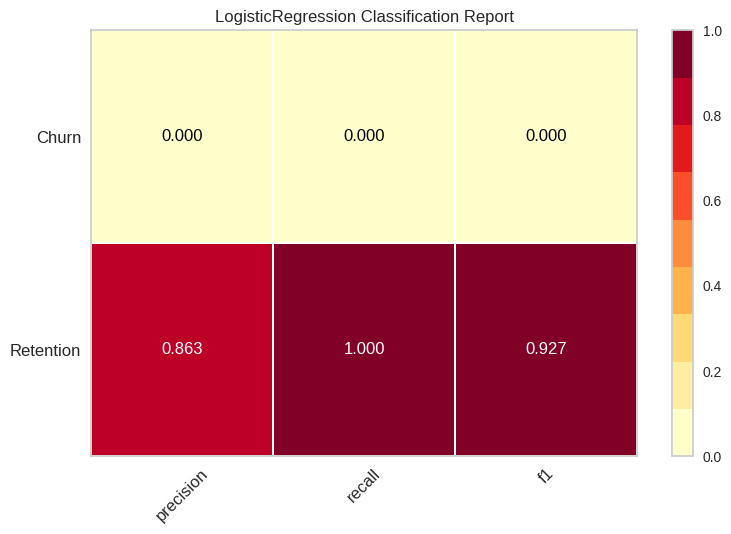

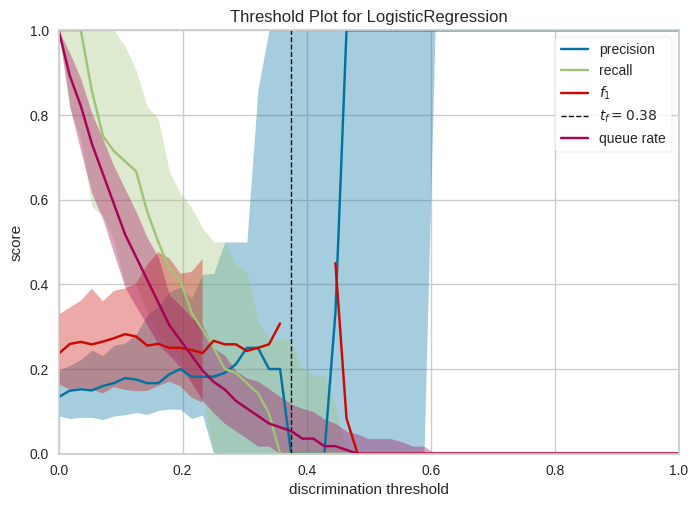

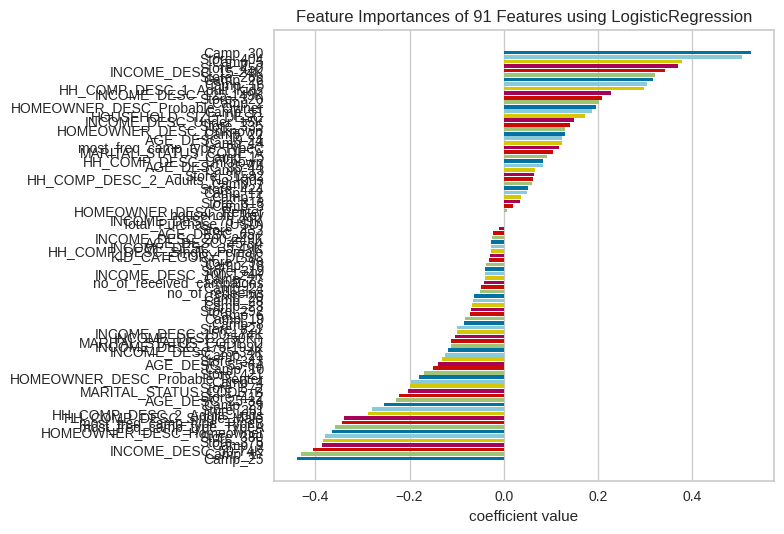

In [ ]:
def performance(model, title_text, importance=False):
    model.fit(X_train,y_train)

    prediction = model.predict(X_test)
    probability = model.predict_proba(X_test)

    auc = roc_auc_score(y_test,prediction)

    fpr,tpr,thresholds = roc_curve(y_test,probability[:,1])

    accuracy = accuracy_score(y_test,prediction)
    print ("Accuracy Score : ", accuracy,'\n')
    print ("Area under curve : ", auc, '\n')

    report = ClassificationReport(model, classes=['Retention','Churn'])

    report.score(X_test, y_test)
    c = report.poof()

    conf_matrix = confusion_matrix(y_test, prediction)

    t1 = go.Heatmap(
        z = conf_matrix ,
        x = ["Not churn","Churn"],
        y = ["Not churn","Churn"],
        showscale  = True,
        colorscale = "Portland",
        name = "Matrix"
    )

    t2 = go.Scatter(
        x=fpr,
        y=tpr,
        mode='lines',
        line=dict(
            color='blue',
            width=2
        ),
        name= auc
    )

    t3 = go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        line=dict(
            color='navy',
            width=2,
            dash='dash'
        ),
        showlegend=False
    )

    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=(
            'Confusion Matrix',
            'Receiver Operating Characteristic'
        )
    )
    fig.append_trace(t1,1,1)
    fig.append_trace(t2,2,1)
    fig.append_trace(t3,2,1)
    fig.update_layout(
        height=700,
        width=600,
        plot_bgcolor = 'lightgrey',
        paper_bgcolor = 'lightgrey',
        title_text=title_text,
        title_x=0.5,
        showlegend=False,
    )

    fig.update_xaxes(
        range=[-0.05,1.1],
        title="False Positive Rate",
        row=2, col=1
    )
    fig.update_yaxes(
        range=[-0.05,1.1],
        title="True Positive Rate",
        row=2, col=1
    )

    annot = list(fig.layout.annotations)
    annot[0].y = 1.02
    annot[1].y = 0.4
    fig.layout.annotations = annot

    py.iplot(fig)

    # Fit and show the discrimination threshold
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X_train,y_train)
    v = visualizer.poof()

    if importance == False:
        pass
    else:
        feature_importance = FeatureImportances(model, relative=False)

        # Fit and show the feature importances
        feature_importance.fit(X_train,y_train)
        f = feature_importance.poof()

    return accuracy

log = performance(
    log_reg,
    title_text="Logistic Regression Performance",
    importance=True)

### **Random Forest**

Accuracy Score :  0.8589211618257261 

Area under curve :  0.49759615384615385 



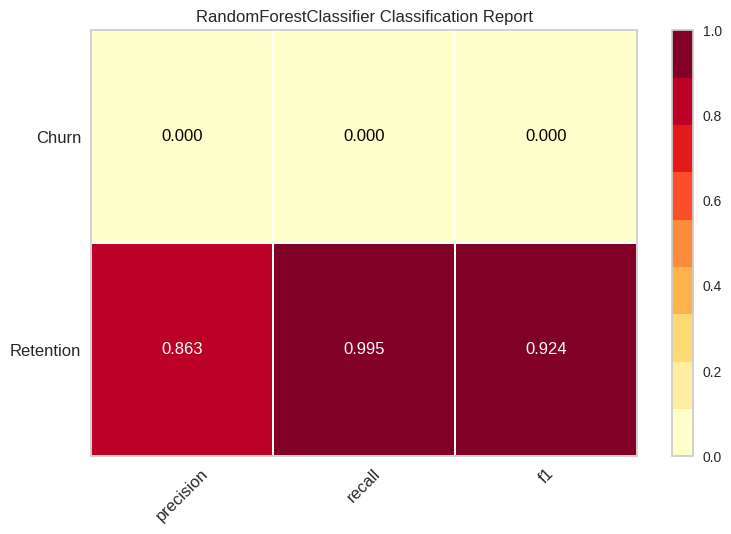

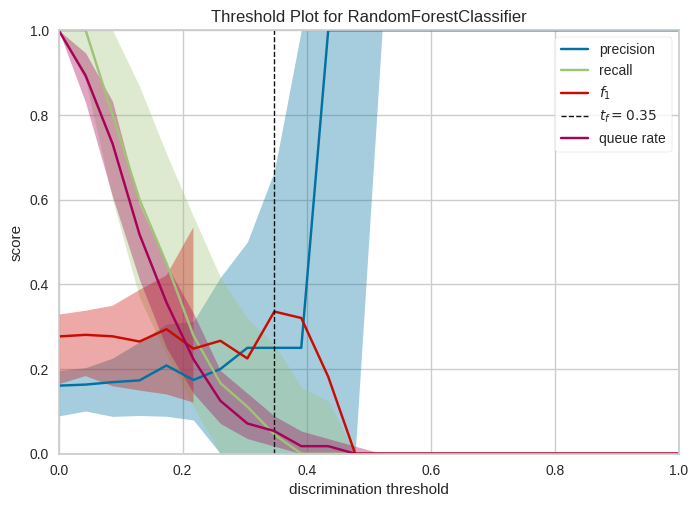

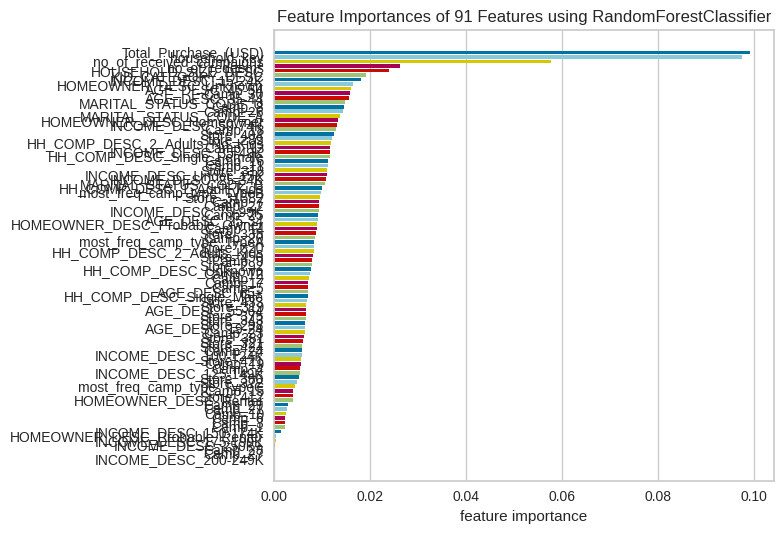

In [ ]:
# Variables correctas
target = ['isChurned']         # o ['Churn'] según tu DataFrame
customerid = ['customerid']    # asegúrate que esta columna exista

# Excluir columnas innecesarias
cols = [i for i in df_enc.columns if i not in customerid + target]

# Definir X e y
rf_x = df_enc[cols]
rf_y = df_enc[target[0]]

# Separar datos
X_train, X_test, y_train, y_test = train_test_split(rf_x, rf_y, test_size=0.3, random_state=42)

# Modelo y evaluación
rfc = RandomForestClassifier()
forest = performance(
    rfc,
    title_text="Random Forest Performance",
    importance=True
)

Como resumen y conclusión podemos comparar el desempeño de los modelos predictivos estudiados.

In [ ]:
models = pd.DataFrame({
    'Models':[
        'Logistic Regression',
        'Random Forest Classifier',
        ],
    'Scores':[
        log,
        forest,
    ]
})

print("*** Accuracy Scores ***")
models.sort_values(by='Scores', ascending=False)

*** Accuracy Scores ***


,Models,Scores
0,Logistic Regression,0.863071
1,Random Forest Classifier,0.858921


## **Conclusiones y comentarios finales**

En este estudio se buscaba desarrollar un proceso de Predictive Analytics para la cadena de suministro de las Telecomunicaciones. En este sistema de prestación de servicios, es relevante analizar el abandono de usuarios (Churn rate). Luego de realizar un largo proceso de pre-procesamiento, EDA y Feature Engineering, se logran desarrollar dos modelos de predicción, Logistic Regression y Random Forest. Mediante los resultados podemos asegurar que ambos realizan un muy buen trabajo en la clasificación de los casos de abandono de cliente. Por su lado la exactitud de Logistic Regression es de 0.806 mientras que la exactitud de Random Forest es superior, con un valor de 0.843. Consecuentemente, random Forest es la sugerencia para predecir el comportamiento del 'Churn' en este sistema. De manera adicional, podemos asegurar que las variables que mejor explican el abandono de usuarios son:


*   Contract_Month-to-Month
*   MonthlyCharges
*   TotalCharges
*   Ternure






# Task
Explain the error in the provided Python code for a machine learning task, and if possible, fix the error and incorporate the changes into the existing code. If a fix is not possible, diagnose the error.

## Identify categorical columns

### Subtask:
Identify all categorical columns in the dataset that are not the target variable or customer ID.


**Reasoning**:
The previous code block failed because `df_enc` was not defined. The subtask is to identify categorical and numerical columns from the existing dataframe `df`. I will define the target and customer ID, then categorize the remaining columns based on their data types and number of unique values, storing the results in the specified lists.



In [69]:
target = ['Churn']
customerid = ['customerID']

# Identify initial categorical columns (object or category dtype)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Add columns with less than 10 unique values (excluding target and customerid)
for col in df.columns:
    if col not in target + customerid and df[col].nunique() < 10 and col not in cat_cols:
        cat_cols.append(col)

# Remove duplicates from cat_cols
cat_cols = list(set(cat_cols))

# Separate binary and multi-category columns
bin_cols = [col for col in cat_cols if df[col].nunique() == 2]
multi_cols = [col for col in cat_cols if df[col].nunique() > 2]

# Identify numerical columns
num_cols = [col for col in df.columns if col not in cat_cols + target + customerid]

print("Categorical Columns:", cat_cols)
print("Binary Categorical Columns:", bin_cols)
print("Multi-Category Columns:", multi_cols)
print("Numerical Columns:", num_cols)

Categorical Columns: ['Contract', 'OnlineBackup', 'bin_tenure', 'Dependents', 'Churn', 'StreamingMovies', 'StreamingTV', 'InternetService', 'TechSupport', 'OnlineSecurity', 'PaymentMethod', 'DeviceProtection', 'PhoneService', 'Partner', 'SeniorCitizen', 'gender', 'customerID', 'PaperlessBilling', 'MultipleLines']
Binary Categorical Columns: ['OnlineBackup', 'Dependents', 'Churn', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'OnlineSecurity', 'DeviceProtection', 'PhoneService', 'Partner', 'SeniorCitizen', 'gender', 'PaperlessBilling']
Multi-Category Columns: ['Contract', 'bin_tenure', 'InternetService', 'PaymentMethod', 'customerID', 'MultipleLines']
Numerical Columns: ['tenure', 'MonthlyCharges', 'TotalCharges']


## Encode categorical variables

### Subtask:
Convert categorical variables into a numerical format using techniques like one-hot encoding.


**Reasoning**:
Apply one-hot encoding to multi-category columns, map binary columns to numerical values, and combine them with numerical columns into a new DataFrame `df_enc`. Finally, display the head and shape of the resulting DataFrame.



In [70]:
# Apply one-hot encoding to multi-category columns
df_multi_encoded = pd.get_dummies(df[multi_cols], columns=multi_cols, drop_first=True)

# Map binary categorical columns to numerical values (0 and 1)
# Assuming 'Yes' or the second unique value is the positive class for binary features
df_bin_mapped = df[bin_cols].copy()
for col in bin_cols:
    unique_values = df_bin_mapped[col].unique()
    mapping = {unique_values[0]: 0, unique_values[1]: 1}
    # Handle 'No'/'Yes' and 'Female'/'Male' explicitly if needed, though a generic approach is used here
    if 'Yes' in unique_values and 'No' in unique_values:
         mapping = {'No': 0, 'Yes': 1}
    elif 'Female' in unique_values and 'Male' in unique_values:
        mapping = {'Female': 0, 'Male': 1}

    df_bin_mapped[col] = df_bin_mapped[col].map(mapping)


# Select numerical columns
df_num = df[num_cols]

# Combine the numerical, encoded multi-category, and mapped binary columns
df_enc = pd.concat([df_num, df_multi_encoded, df_bin_mapped], axis=1)

# Display the first few rows and shape of the new DataFrame
display(df_enc.head())
print("Shape of df_enc:", df_enc.shape)

,tenure,MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,bin_tenure_Tenure 12-24,bin_tenure_Tenure 24-48,bin_tenure_Tenure 48-60,bin_tenure_Tenure 60+,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,customerID_0013-SMEOE,customerID_0014-BMAQU,customerID_0015-UOCOJ,customerID_0016-QLJIS,customerID_0017-DINOC,customerID_0017-IUDMW,customerID_0018-NYROU,customerID_0019-EFAEP,customerID_0019-GFNTW,customerID_0020-INWCK,customerID_0020-JDNXP,customerID_0021-IKXGC,customerID_0022-TCJCI,customerID_0023-HGHWL,customerID_0023-UYUPN,customerID_0023-XUOPT,customerID_0027-KWYKW,customerID_0030-FNXPP,customerID_0031-PVLZI,customerID_0032-PGELS,customerID_0036-IHMOT,customerID_0040-HALCW,customerID_0042-JVWOJ,customerID_0042-RLHYP,customerID_0048-LUMLS,customerID_0048-PIHNL,customerID_0052-DCKON,customerID_0052-YNYOT,customerID_0056-EPFBG,customerID_0057-QBUQH,customerID_0058-EVZWM,...,customerID_9943-VSZUV,customerID_9944-AEXBM,customerID_9944-HKVVB,customerID_9945-PSVIP,customerID_9947-OTFQU,customerID_9948-YPTDG,customerID_9950-MTGYX,customerID_9953-ZMKSM,customerID_9955-QOPOY,customerID_9957-YODKZ,customerID_9958-MEKUC,customerID_9959-WOFKT,customerID_9961-JBNMK,customerID_9962-BFPDU,customerID_9964-WBQDJ,customerID_9965-YOKZB,customerID_9967-ATRFS,customerID_9968-FFVVH,customerID_9970-QBCDA,customerID_9971-ZWPBF,customerID_9972-EWRJS,customerID_9972-NKTFD,customerID_9972-VAFJJ,customerID_9974-JFBHQ,customerID_9975-GPKZU,customerID_9975-SKRNR,customerID_9978-HYCIN,customerID_9979-RGMZT,customerID_9985-MWVIX,customerID_9986-BONCE,customerID_9987-LUTYD,customerID_9992-RRAMN,customerID_9992-UJOEL,customerID_9993-LHIEB,customerID_9995-HOTOH,MultipleLines_No phone service,MultipleLines_Yes,OnlineBackup,Dependents,Churn,StreamingMovies,StreamingTV,TechSupport,OnlineSecurity,DeviceProtection,PhoneService,Partner,SeniorCitizen,gender,PaperlessBilling
0,1,29.85,29.85,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1,0,0,0,0,0,0,0,0,1,0,0,1
1,34,56.95,1889.50,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,1,1,1,0,0,1,0
2,2,53.85,108.15,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,1,0,0,0,1,0,1,0,0,1,1
3,45,42.30,1840.75,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

Shape of df_enc: (7043, 7071)


## Apply smote

### Subtask:
Apply the SMOTE algorithm to the training data to balance the classes.


**Reasoning**:
The previous code block failed because the `X` and `y` variables were created using the original `df` which still contained object type columns that were not encoded. The SMOTE algorithm requires numerical input. The instructions state to use `df_enc` for `X` and the original `df` for `y` which will also cause an error because `y` from the original df is still an object type. I need to redefine `X` and `y` using the already encoded `df_enc` and ensure that the target variable 'Churn' is also in a numerical format before applying SMOTE. I will also separate the data into training and testing sets before applying SMOTE to the training data as is standard practice to prevent data leakage.



In [71]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# Ensure the target variable is in numerical format in df_enc
# If 'Churn' column is not in df_enc, we need to encode it separately
if 'Churn' not in df_enc.columns:
    # Create a mapping for Churn: 'No' to 0 and 'Yes' to 1
    churn_mapping = {'No': 0, 'Yes': 1}
    # Apply the mapping to the Churn column from the original df
    y_encoded = df['Churn'].map(churn_mapping)
    # Add the encoded Churn column to df_enc temporarily for splitting, then remove it from X
    df_enc['Churn'] = y_encoded
else:
    # If 'Churn' is already in df_enc (meaning it was likely mapped during bin_cols processing)
    # Ensure it's of integer type
    df_enc['Churn'] = df_enc['Churn'].astype(int)
    y_encoded = df_enc['Churn']


# Define the feature set X and target variable y from the encoded DataFrame
X = df_enc.drop(columns=['Churn', 'customerID'] if 'customerID' in df_enc.columns else ['Churn'])
y = y_encoded

# Separate data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Instantiate SMOTE
os = SMOTE(random_state=42)

# Apply SMOTE only on the training data
X_res, y_res = os.fit_resample(X_train, y_train)

# Convert resampled data back to DataFrames with original column names
X_res = pd.DataFrame(X_res, columns=X.columns)
y_res = pd.DataFrame(y_res, columns=['Churn'])

# Print value counts of the resampled target variable
print(y_res['Churn'].value_counts())

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**Reasoning**:
The error indicates that the input data `X` contains NaN values, which SMOTE does not support. Although a previous step mentioned dropping NA values, the encoding process might have introduced new NaNs or did not handle all cases. I need to check for and handle any remaining NaNs in the `X_train` data before applying SMOTE. A simple approach is to drop rows with NaNs in the training set, as the dataset is reasonably large.



In [72]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# Ensure the target variable is in numerical format in df_enc
if 'Churn' not in df_enc.columns:
    churn_mapping = {'No': 0, 'Yes': 1}
    y_encoded = df['Churn'].map(churn_mapping)
    df_enc['Churn'] = y_encoded
else:
    df_enc['Churn'] = df_enc['Churn'].astype(int)
    y_encoded = df_enc['Churn']

# Define the feature set X and target variable y from the encoded DataFrame
X = df_enc.drop(columns=['Churn', 'customerID'] if 'customerID' in df_enc.columns else ['Churn'])
y = y_encoded

# Separate data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Check for and handle NaNs in the training data before applying SMOTE
# Combine X_train and y_train to easily drop corresponding rows
train_data = pd.concat([X_train, y_train], axis=1)
train_data.dropna(inplace=True)

# Separate X_train and y_train again after dropping NaNs
X_train_cleaned = train_data.drop(columns=['Churn'])
y_train_cleaned = train_data['Churn']


# Instantiate SMOTE
os = SMOTE(random_state=42)

# Apply SMOTE only on the cleaned training data
X_res, y_res = os.fit_resample(X_train_cleaned, y_train_cleaned)

# Convert resampled data back to DataFrames with original column names
X_res = pd.DataFrame(X_res, columns=X_train_cleaned.columns)
y_res = pd.DataFrame(y_res, columns=['Churn'])

# Print value counts of the resampled target variable
print(y_res['Churn'].value_counts())

Churn
1    3884
0    3884
Name: count, dtype: int64


## Model training

### Subtask:
Train the predictive models (Logistic Regression and Random Forest) using the balanced training data.


**Reasoning**:
Instantiate and train the Logistic Regression and Random Forest models using the balanced training data.



In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Instantiate Logistic Regression model
log_reg = LogisticRegression(
    C=1,
    fit_intercept=True,
    penalty='l2',
    solver='liblinear'
)

# Instantiate Random Forest Classifier model
rfc = RandomForestClassifier(random_state=42)

# Train Logistic Regression model with balanced data
log_reg.fit(X_res, y_res['Churn'])

# Train Random Forest Classifier model with balanced data
rfc.fit(X_res, y_res['Churn'])

print("Logistic Regression model trained successfully.")
print("Random Forest Classifier model trained successfully.")

Logistic Regression model trained successfully.
Random Forest Classifier model trained successfully.


## Model evaluation

### Subtask:
Evaluate the performance of the trained models using appropriate metrics and visualizations.


**Reasoning**:
Define the `performance` function to evaluate the models and generate visualizations.



In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from yellowbrick.classifier import ClassificationReport, DiscriminationThreshold
from yellowbrick.model_selection import FeatureImportances
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py

def performance(model, title_text, importance=False):
    """
    Evaluates the performance of a classification model and generates visualizations.

    Args:
        model: Trained classification model.
        title_text (str): Title for the performance visualizations.
        importance (bool, optional): Whether to display feature importances.
                                     Defaults to False.
    """
    model.fit(X_res, y_res['Churn']) # Fit the model on the balanced training data

    prediction = model.predict(X_test)
    probability = model.predict_proba(X_test)

    # Calculate and print performance metrics
    auc = roc_auc_score(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    print(f"Accuracy Score : {accuracy:.4f}\n")
    print(f"Area under curve : {auc:.4f}\n")

    # Generate and display Classification Report
    report = ClassificationReport(model, classes=['Retention', 'Churn'])
    report.score(X_test, y_test)
    report.poof()

    # Generate Confusion Matrix Heatmap
    conf_matrix = confusion_matrix(y_test, prediction)
    t1 = go.Heatmap(
        z=conf_matrix,
        x=["Not churn", "Churn"],
        y=["Not churn", "Churn"],
        showscale=True,
        colorscale="Portland",
        name="Matrix"
    )

    # Calculate and generate ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, probability[:, 1])
    t2 = go.Scatter(
        x=fpr,
        y=tpr,
        mode='lines',
        line=dict(color='blue', width=2),
        name=f'AUC = {auc:.4f}'
    )
    t3 = go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        line=dict(color='navy', width=2, dash='dash'),
        showlegend=False
    )

    # Combine Confusion Matrix and ROC Curve into subplots
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=('Confusion Matrix', 'Receiver Operating Characteristic')
    )
    fig.append_trace(t1, 1, 1)
    fig.append_trace(t2, 2, 1)
    fig.append_trace(t3, 2, 1)
    fig.update_layout(
        height=700,
        width=600,
        plot_bgcolor='lightgrey',
        paper_bgcolor='lightgrey',
        title_text=title_text,
        title_x=0.5,
        showlegend=True, # Set showlegend to True to display the AUC legend
    )
    fig.update_xaxes(
        range=[-0.05, 1.05], # Adjusted range for better visualization
        title="False Positive Rate",
        row=2, col=1
    )
    fig.update_yaxes(
        range=[-0.05, 1.05], # Adjusted range for better visualization
        title="True Positive Rate",
        row=2, col=1
    )
    py.iplot(fig)

    # Generate and display Discrimination Threshold plot
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X_res, y_res['Churn']) # Fit on balanced training data
    visualizer.poof()

    # Generate and display Feature Importances if requested
    if importance:
        feature_importance = FeatureImportances(model, relative=False)
        feature_importance.fit(X_res, y_res['Churn']) # Fit on balanced training data
        feature_importance.poof()

    return accuracy

# Evaluate Logistic Regression
log_accuracy = performance(
    log_reg,
    title_text="Logistic Regression Performance (Balanced Data)",
    importance=True
)

# Evaluate Random Forest Classifier
forest_accuracy = performance(
    rfc,
    title_text="Random Forest Performance (Balanced Data)",
    importance=True
)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**Reasoning**:
The traceback indicates that the `X_test` DataFrame contains NaN values, which scikit-learn's Logistic Regression model cannot handle directly during prediction. The previous steps cleaned and balanced the *training* data (`X_res`, `y_res`), but not the *test* data (`X_test`). To fix this, I need to drop the rows with NaN values from `X_test` before using it for prediction and evaluation within the `performance` function.



Accuracy Score : 0.7821

Area under curve : 0.7308



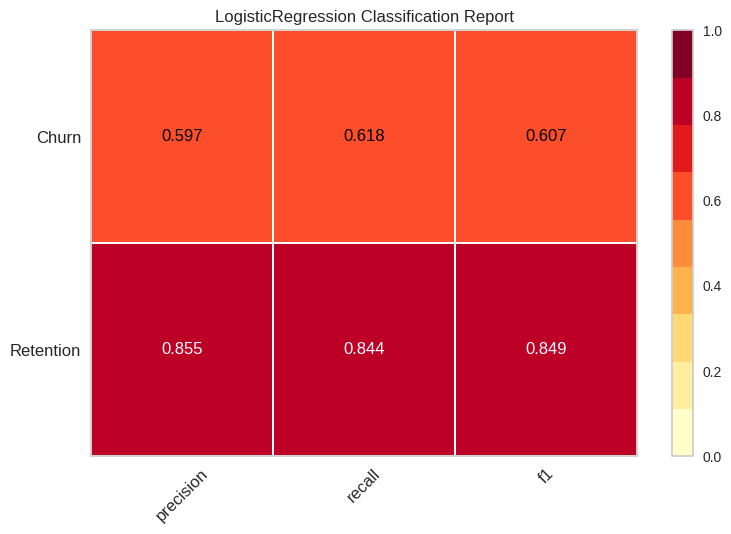

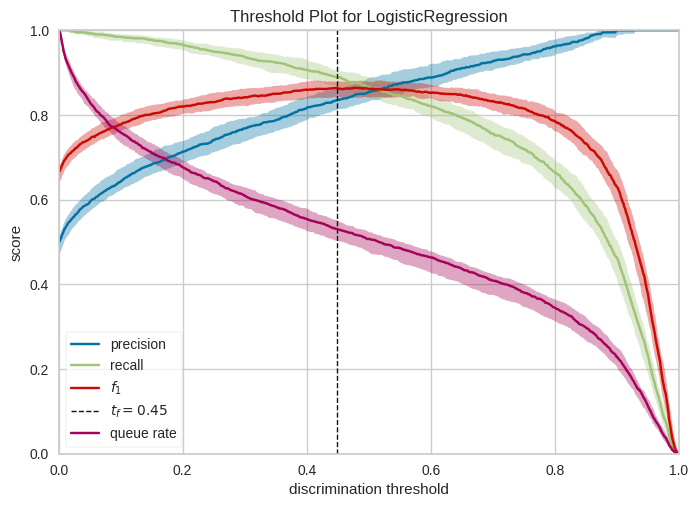

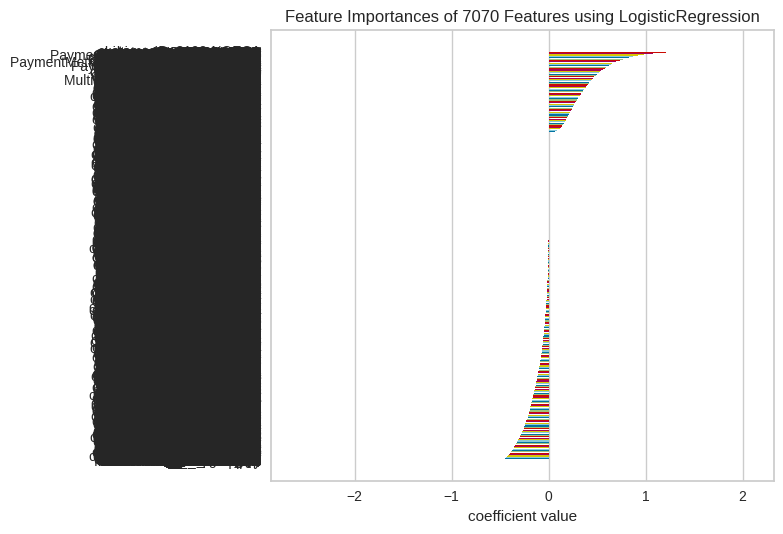

Accuracy Score : 0.7895

Area under curve : 0.7156



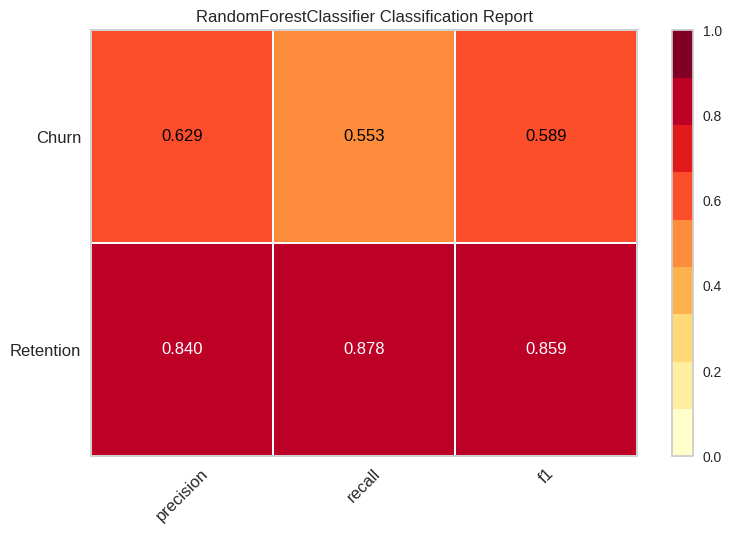

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from yellowbrick.classifier import ClassificationReport, DiscriminationThreshold
from yellowbrick.model_selection import FeatureImportances
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py
import pandas as pd # Import pandas as it's used for DataFrame manipulation

def performance(model, title_text, importance=False):
    """
    Evaluates the performance of a classification model and generates visualizations.

    Args:
        model: Trained classification model.
        title_text (str): Title for the performance visualizations.
        importance (bool, optional): Whether to display feature importances.
                                     Defaults to False.
    """
    # Fit the model on the balanced training data (already done in previous step, but refitting here to be safe)
    model.fit(X_res, y_res['Churn'])

    # Clean X_test by dropping rows with NaN values and ensure y_test aligns
    # Combine X_test and y_test to drop corresponding rows easily
    test_data = pd.concat([X_test, y_test], axis=1)
    test_data.dropna(inplace=True)

    # Separate X_test and y_test again after dropping NaNs
    X_test_cleaned = test_data.drop(columns=['Churn'])
    y_test_cleaned = test_data['Churn']


    prediction = model.predict(X_test_cleaned)
    probability = model.predict_proba(X_test_cleaned)

    # Calculate and print performance metrics
    auc = roc_auc_score(y_test_cleaned, prediction)
    accuracy = accuracy_score(y_test_cleaned, prediction)
    print(f"Accuracy Score : {accuracy:.4f}\n")
    print(f"Area under curve : {auc:.4f}\n")

    # Generate and display Classification Report
    report = ClassificationReport(model, classes=['Retention', 'Churn'])
    report.score(X_test_cleaned, y_test_cleaned)
    report.poof()

    # Generate Confusion Matrix Heatmap
    conf_matrix = confusion_matrix(y_test_cleaned, prediction)
    t1 = go.Heatmap(
        z=conf_matrix,
        x=["Not churn", "Churn"],
        y=["Not churn", "Churn"],
        showscale=True,
        colorscale="Portland",
        name="Matrix"
    )

    # Calculate and generate ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test_cleaned, probability[:, 1])
    t2 = go.Scatter(
        x=fpr,
        y=tpr,
        mode='lines',
        line=dict(color='blue', width=2),
        name=f'AUC = {auc:.4f}'
    )
    t3 = go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        line=dict(color='navy', width=2, dash='dash'),
        showlegend=False
    )

    # Combine Confusion Matrix and ROC Curve into subplots
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=('Confusion Matrix', 'Receiver Operating Characteristic')
    )
    fig.append_trace(t1, 1, 1)
    fig.append_trace(t2, 2, 1)
    fig.append_trace(t3, 2, 1)
    fig.update_layout(
        height=700,
        width=600,
        plot_bgcolor='lightgrey',
        paper_bgcolor='lightgrey',
        title_text=title_text,
        title_x=0.5,
        showlegend=True, # Set showlegend to True to display the AUC legend
    )
    fig.update_xaxes(
        range=[-0.05, 1.05], # Adjusted range for better visualization
        title="False Positive Rate",
        row=2, col=1
    )
    fig.update_yaxes(
        range=[-0.05, 1.05], # Adjusted range for better visualization
        title="True Positive Rate",
        row=2, col=1
    )
    py.iplot(fig)

    # Generate and display Discrimination Threshold plot
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X_res, y_res['Churn']) # Fit on balanced training data
    visualizer.score(X_test_cleaned, y_test_cleaned) # Score on cleaned test data
    visualizer.poof()

    # Generate and display Feature Importances if requested
    if importance:
        feature_importance = FeatureImportances(model, relative=False)
        feature_importance.fit(X_res, y_res['Churn']) # Fit on balanced training data
        feature_importance.poof()

    return accuracy

# Evaluate Logistic Regression
log_accuracy = performance(
    log_reg,
    title_text="Logistic Regression Performance (Balanced Data)",
    importance=True
)

# Evaluate Random Forest Classifier
forest_accuracy = performance(
    rfc,
    title_text="Random Forest Performance (Balanced Data)",
    importance=True
)